In [1]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.1.1-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import csv
import pyspark.sql
import pandas as pd
from fbprophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [9]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [10]:
# import the necessary pyspark and pandas libraries

from pyspark.sql.functions import pandas_udf, PandasUDFType, current_date
from pyspark.sql.types import StructType,StructField,StringType,LongType,DoubleType,FloatType

import statsmodels.tsa.api as sm
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [11]:
aqi_list = []
for i in range(2000, 2020):
  df = pd.read_csv('/content/drive/MyDrive/Project/Data/daily_aqi_by_county_{}.csv'.format(str(i)))
  aqi_list.append(df)

aqi_df= pd.concat(aqi_list)
aqi_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,01,3,2000-01-16,25,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,01,3,2000-01-19,46,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,01,3,2000-01-22,36,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,01,3,2000-01-25,26,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,01,3,2000-01-28,32,Good,PM2.5,01-003-0010,1


In [12]:
# converting the col names into lowercase
aqi_df = aqi_df.rename(columns={"State Name" : "state_name", "county Name" : "county_name", "State Code" : "state_code", "County Code" : "county_code", "Date" : "date", "AQI" : "aqi", "Category" : "category", "Defining Parameter" : "defining_parameter", "Defining Site" : "defining_site", "Number of Sites Reporting" : "num_of_sites_reporting"})

In [13]:
aqi_df.head()

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,num_of_sites_reporting
0,Alabama,Baldwin,01,3,2000-01-16,25,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,01,3,2000-01-19,46,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,01,3,2000-01-22,36,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,01,3,2000-01-25,26,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,01,3,2000-01-28,32,Good,PM2.5,01-003-0010,1


In [14]:
aqi_df['date'] = pd.to_datetime(aqi_df['date'], infer_datetime_format= True)

In [15]:
aqi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6489592 entries, 0 to 341944
Data columns (total 10 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   state_name              object        
 1   county_name             object        
 2   state_code              object        
 3   county_code             int64         
 4   date                    datetime64[ns]
 5   aqi                     int64         
 6   category                object        
 7   defining_parameter      object        
 8   defining_site           object        
 9   num_of_sites_reporting  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 544.6+ MB


In [16]:
print("\n Missing values: ", aqi_df.isnull().any())
print("\n Unique values: ", aqi_df.nunique())


 Missing values:  state_name                False
county_name               False
state_code                False
county_code               False
date                      False
aqi                       False
category                  False
defining_parameter        False
defining_site             False
num_of_sites_reporting    False
dtype: bool

 Unique values:  state_name                  55
county_name               1004
state_code                  69
county_code                190
date                      7305
aqi                        812
category                     6
defining_parameter           6
defining_site             4762
num_of_sites_reporting      39
dtype: int64


In [17]:
plot_df = aqi_df.set_index('date')

In [18]:
plot_df['county_code'].value_counts()

3      178501
1      173166
13     152711
5      149643
33     124552
        ...  
235       132
232       125
211       107
130        90
188        21
Name: county_code, Length: 190, dtype: int64

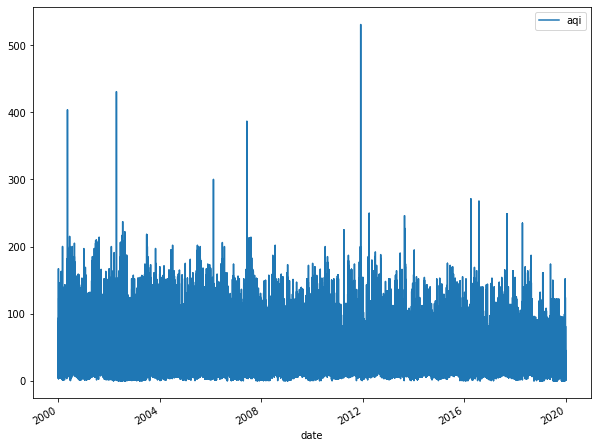

In [19]:
plot_df.query("county_code == 3")[['aqi']].plot()

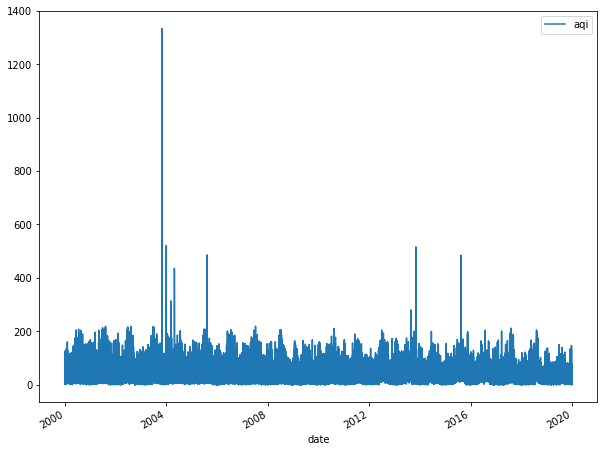

In [20]:
plot_df.query("county_code == 5")[['aqi']].plot()

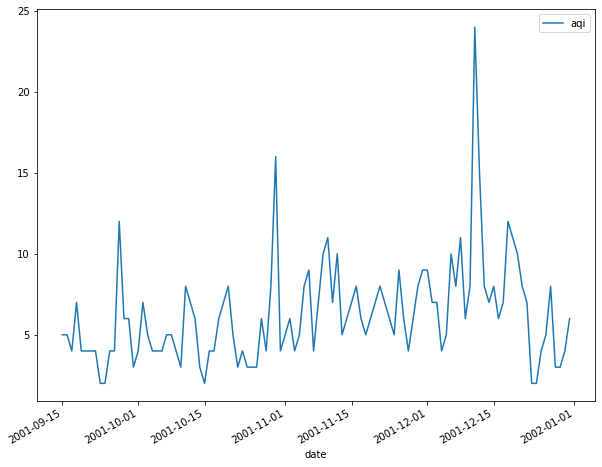

In [21]:
plot_df.query("county_code == 211")[['aqi']].plot()

In [22]:
df = spark.read.csv("/content/drive/MyDrive/Project/Data/*.csv", header=True)
df.show(5)

+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|   Alabama|    Baldwin|        01|        003|2018-01-02| 32|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-05| 34|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-08| 15|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-11| 19|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-14| 25|    Good|            

In [23]:
df.printSchema()

root
 |-- State Name: string (nullable = true)
 |-- county Name: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- County Code: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- AQI: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining Parameter: string (nullable = true)
 |-- Defining Site: string (nullable = true)
 |-- Number of Sites Reporting: string (nullable = true)



In [24]:
df.show(5)

+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|   Alabama|    Baldwin|        01|        003|2018-01-02| 32|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-05| 34|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-08| 15|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-11| 19|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-14| 25|    Good|            

In [25]:
state_df = df.filter((df['State Name'] == "California"))
state_df = state_df.filter(df['county Name'] == "Kern")
cal_aqi = state_df.orderBy("Date")
cal_aqi.show(5)

+----------+-----------+----------+-----------+----------+---+--------------------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|            Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------------------+------------------+-------------+-------------------------+
|California|       Kern|        06|        029|1980-01-01| 81|            Moderate|               SO2|  06-029-0230|                        2|
|California|       Kern|        06|        029|1980-01-02| 47|                Good|               NO2|  06-029-0004|                        2|
|California|       Kern|        06|        029|1980-01-03|107|Unhealthy for Sen...|               SO2|  06-029-0230|                        2|
|California|       Kern|        06|        029|1980-01-04|134|Unhealthy for Sen...|               SO2|  06-029-0230|                        2|

In [26]:
cali_df = cal_aqi.select('State Name', 'State Code', 'County Name', 'County Code', 'Date', 'AQI', 'Defining Parameter', 'Category')
cali_df.show(5)

+----------+----------+-----------+-----------+----------+---+------------------+--------------------+
|State Name|State Code|County Name|County Code|      Date|AQI|Defining Parameter|            Category|
+----------+----------+-----------+-----------+----------+---+------------------+--------------------+
|California|        06|       Kern|        029|1980-01-01| 81|               SO2|            Moderate|
|California|        06|       Kern|        029|1980-01-02| 47|               NO2|                Good|
|California|        06|       Kern|        029|1980-01-03|107|               SO2|Unhealthy for Sen...|
|California|        06|       Kern|        029|1980-01-04|134|               SO2|Unhealthy for Sen...|
|California|        06|       Kern|        029|1980-01-05|143|               SO2|Unhealthy for Sen...|
+----------+----------+-----------+-----------+----------+---+------------------+--------------------+
only showing top 5 rows



In [27]:
spark_aqi_df = cali_df.withColumnRenamed("State Name","state_name") \
    .withColumnRenamed("State Code","state_code") \
    .withColumnRenamed("County Name","county_name") \
    .withColumnRenamed("County Code","county_code") \
    .withColumnRenamed("Date","date") \
    .withColumnRenamed("AQI","aqi") \
    .withColumnRenamed("Defining Parameter","defining_parameter") \
    .withColumnRenamed("Category","category")

spark_aqi_df.take(5)

[Row(state_name='California', state_code='06', county_name='Kern', county_code='029', date='1980-01-01', aqi='81', defining_parameter='SO2', category='Moderate'),
 Row(state_name='California', state_code='06', county_name='Kern', county_code='029', date='1980-01-02', aqi='47', defining_parameter='NO2', category='Good'),
 Row(state_name='California', state_code='06', county_name='Kern', county_code='029', date='1980-01-03', aqi='107', defining_parameter='SO2', category='Unhealthy for Sensitive Groups'),
 Row(state_name='California', state_code='06', county_name='Kern', county_code='029', date='1980-01-04', aqi='134', defining_parameter='SO2', category='Unhealthy for Sensitive Groups'),
 Row(state_name='California', state_code='06', county_name='Kern', county_code='029', date='1980-01-05', aqi='143', defining_parameter='SO2', category='Unhealthy for Sensitive Groups')]

In [28]:
# converting the Date column datatype from string -> timestamp
spark_aqi_df = spark_aqi_df.withColumn("date", spark_aqi_df["date"].cast(TimestampType()))

In [29]:
spark_aqi_df.schema

StructType(List(StructField(state_name,StringType,true),StructField(state_code,StringType,true),StructField(county_name,StringType,true),StructField(county_code,StringType,true),StructField(date,TimestampType,true),StructField(aqi,StringType,true),StructField(defining_parameter,StringType,true),StructField(category,StringType,true)))

In [31]:
spark_aqi_df.createOrReplaceTempView("aqi")

In [32]:
sql_df = spark.sql('SELECT county_code, date as ds, double(aqi) as y FROM aqi')
sql_df = sql_df.filter(sql_df.county_code.isNotNull()) 
sql_df.show()

+-----------+-------------------+-----+
|county_code|                 ds|    y|
+-----------+-------------------+-----+
|        029|1980-01-01 00:00:00| 81.0|
|        029|1980-01-02 00:00:00| 47.0|
|        029|1980-01-03 00:00:00|107.0|
|        029|1980-01-04 00:00:00|134.0|
|        029|1980-01-05 00:00:00|143.0|
|        029|1980-01-06 00:00:00|134.0|
|        029|1980-01-07 00:00:00|107.0|
|        029|1980-01-08 00:00:00| 81.0|
|        029|1980-01-09 00:00:00| 69.0|
|        029|1980-01-10 00:00:00| 30.0|
|        029|1980-01-11 00:00:00| 43.0|
|        029|1980-01-12 00:00:00| 69.0|
|        029|1980-01-13 00:00:00| 69.0|
|        029|1980-01-14 00:00:00| 56.0|
|        029|1980-01-15 00:00:00| 56.0|
|        029|1980-01-16 00:00:00| 94.0|
|        029|1980-01-17 00:00:00| 56.0|
|        029|1980-01-18 00:00:00| 38.0|
|        029|1980-01-19 00:00:00| 43.0|
|        029|1980-01-20 00:00:00| 56.0|
+-----------+-------------------+-----+
only showing top 20 rows



In [ ]:
print((sql_df.count(), len(sql_df.columns)))

In [33]:
aqi_part = (sql_df.repartition(spark.sparkContext.defaultParallelism, ['county_code'])).cache()

**Training the Model**

In [ ]:
aqi_part.explain()

In [34]:
schema = StructType([
                     StructField('ds', TimestampType()),
                     StructField('county_code', StringType()),
                     StructField('y', DoubleType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType())
                     ])


In [35]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)

def forecast_aqi(pd_aqi):
  aqi_model = Prophet(
      interval_width=0.95, 
      seasonality_mode='multiplicative', 
      weekly_seasonality=True, 
      yearly_seasonality=True)
  
  print(aqi_model.history)
  aqi_model.fit(pd_aqi)

  future_pd = aqi_model.make_future_dataframe(periods=5, freq='w')

  forecast_pd = aqi_model.predict(future_pd)
  print(forecast_pd)
  
  f_pd = forecast_pd[['ds','yhat','yhat_upper','yhat_lower']].set_index('ds')
  aq_pd = pd_aqi[['ds', 'county_code', 'y']].set_index('ds')

  results_pd = f_pd.join(aq_pd, how="left")
  results_pd.reset_index(level=0, inplace=True)

  results_pd['county_code'] = pd_aqi['county_code'].iloc[0]

  return results_pd[['ds', 'county_code', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [36]:
aqi_result = (
    aqi_part
    .groupBy('county_code')
    .apply(forecast_aqi)
    .withColumn('training_date', current_date())
)

spark-3.1.1-bin-hadoop2.7/python/pyspark/sql/pandas/group_ops.py:84: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [37]:
aqi_result = aqi_result.dropna(how='any')

In [38]:
aqi_result.cache()

DataFrame[ds: timestamp, county_code: string, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [ ]:
aqi_result.show()

**Predicting the future AQI Values**

In [ ]:
aqi_result.count()

In [57]:
aqi_result.createOrReplaceTempView("forecast_aqi")
aqi_result.show()

+-------------------+-----------+-----+-----------------+------------------+-------------------+-------------+
|                 ds|county_code|    y|             yhat|        yhat_upper|         yhat_lower|training_date|
+-------------------+-----------+-----+-----------------+------------------+-------------------+-------------+
|1980-01-01 00:00:00|        029| 81.0|80.86127084371445| 161.4203387862635|  1.366800149386766|   2021-05-03|
|1980-01-02 00:00:00|        029| 47.0|82.25326142238399| 161.5905439202943|  5.111556278838923|   2021-05-03|
|1980-01-03 00:00:00|        029|107.0|81.43862999073292|159.25671296940584| 0.2892960278979679|   2021-05-03|
|1980-01-04 00:00:00|        029|134.0|82.93108624866527|161.59842729350217|  8.476607536232457|   2021-05-03|
|1980-01-05 00:00:00|        029|143.0|83.49893114171645|160.43181667956583|  10.05029505645177|   2021-05-03|
|1980-01-06 00:00:00|        029|134.0|78.76132560855727|151.77179777920855|0.25192382343580033|   2021-05-03|
|

In [58]:
final_result_df = aqi_result.toPandas()

type(final_result_df)

pandas.core.frame.DataFrame

In [53]:
#final_result_df = final_result_df.set_index('ds')

In [59]:
final_result_df 

,ds,county_code,y,yhat,yhat_upper,yhat_lower,training_date
0,1980-01-01,029,81.0,80.861271,161.420339,1.366800,2021-05-03
1,1980-01-02,029,47.0,82.253261,161.590544,5.111556,2021-05-03
2,1980-01-03,029,107.0,81.438630,159.256713,0.289296,2021-05-03
3,1980-01-04,029,134.0,82.931086,161.598427,8.476608,2021-05-03
4,1980-01-05,029,143.0,83.498931,160.431817,10.050295,2021-05-03
...,...,...,...,...,...,...,...
14817,2020-07-28,029,51.0,113.510820,192.958198,40.076294,2021-05-03
14818,2020-07-29,029,64.0,114.890909,186.056755,39.085664,2021-05-03
14819,2020-07-30,029,80.0,114.589895,191.973688,39.301025,2021-05-03
14820,2020-07-31,029,74.0,115.930467,194.074140,33.219226,2021-05-03


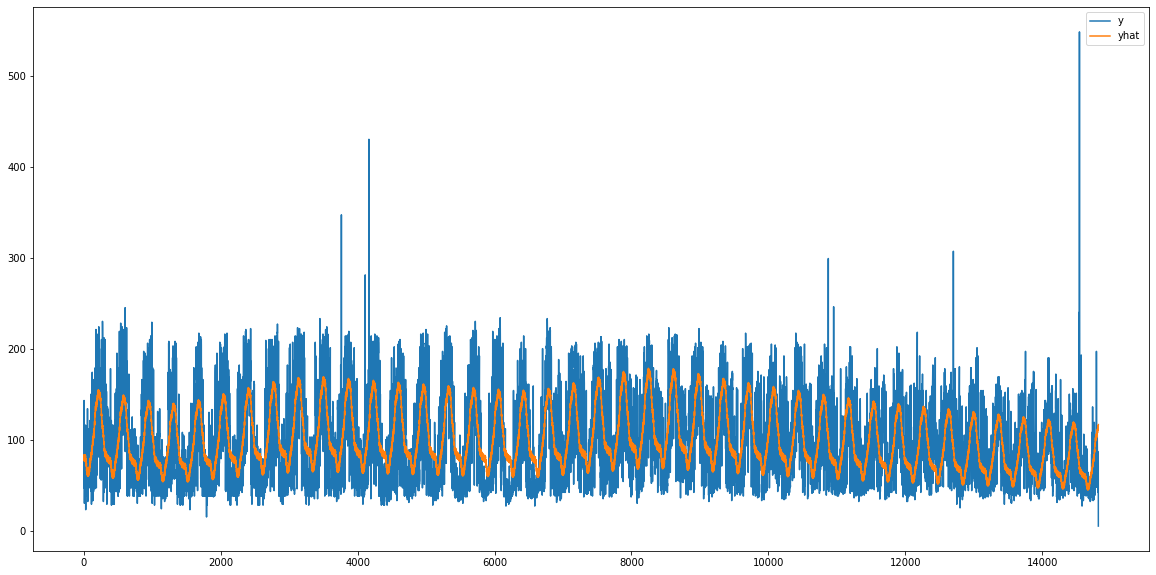

In [60]:
final_result_df[['y','yhat']].plot()

In [61]:
final_sampled = final_result_df.loc[(final_result_df['ds'] >= '2019-01-01')]

**Graph for predicted and actual values for 2019 and 2020**

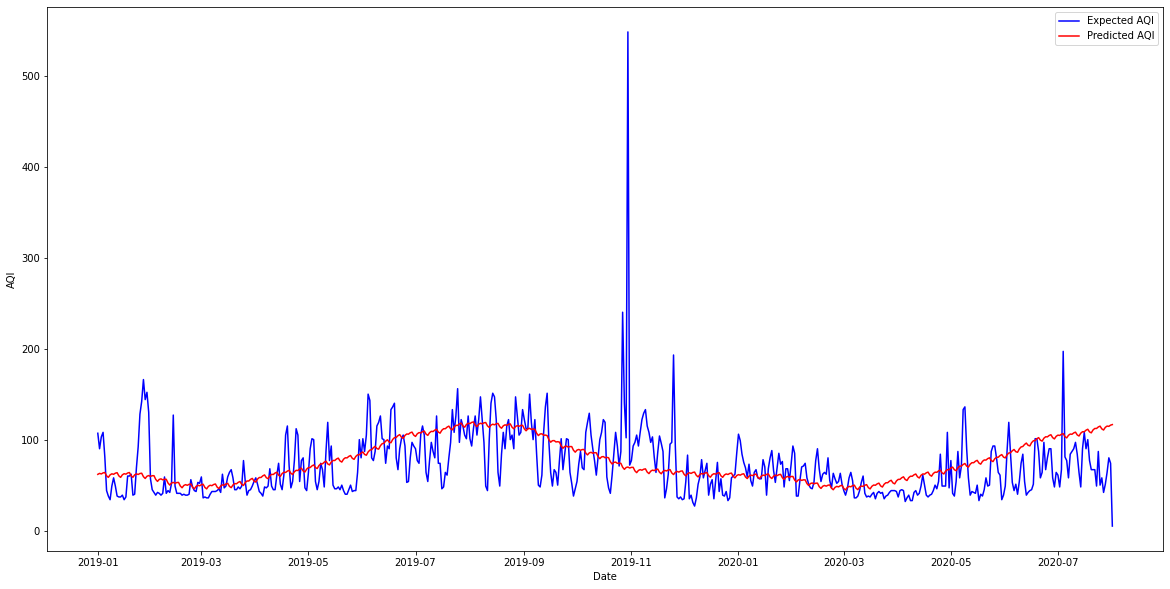

In [62]:

import matplotlib

import matplotlib.pyplot as plt

datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d")
fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
plt.rcParams['figure.figsize'] = (20, 10)
plt.gca().format_coord = fmt
final_result_df = final_sampled.reset_index()
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(final_sampled["ds"],final_sampled["y"].to_list(),'b',label='Expected AQI')
plt.plot(final_sampled["ds"],final_sampled["yhat"].to_list(),'r',label='Predicted AQI')
plt.legend(loc='best')
plt.show()

In [ ]:
"""def rounding(val):
  val = int(val)#,2)

  return val

r1 = final_result_df['y'].apply(rounding).to_list()
r2 = final_result_df['yhat'].apply(rounding).to_list()"""


In [63]:
import math
import numpy as np
final_result_df.reset_index(drop=True)
y_forecasted = final_result_df["yhat"] #np.array(r2) 
y_truth = final_result_df["y"]  #np.array(r1)
# Compute the mean square error
rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The root Mean Squared Error of our forecasts is {}'.format(rmse))

The root Mean Squared Error of our forecasts is 35.41409104325766


## Forecasting for next 2 years

In [119]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)

def future_forecast_aqi(pd_aqi):
  aqi_model = Prophet(
      interval_width=0.95, 
      seasonality_mode='multiplicative', 
      weekly_seasonality=True, 
      yearly_seasonality=True,
      daily_seasonality = True)
  
  print(aqi_model.history)
  aqi_model.fit(pd_aqi)

  future_pd = aqi_model.make_future_dataframe(periods=190, freq='d')

  forecast_pd = aqi_model.predict(future_pd)
  
  f_pd = forecast_pd[['ds','yhat','yhat_upper','yhat_lower']].set_index('ds')

  aq_pd = pd_aqi[['ds', 'county_code', 'y']].set_index('ds')

  results_pd = f_pd.join(aq_pd, how="left")
  results_pd.reset_index(level=0, inplace=True)

  results_pd['county_code'] = pd_aqi['county_code'].iloc[0]

  return results_pd[['ds', 'county_code', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [120]:
future_aqi_result = (
    aqi_part
    .groupBy('county_code')
    .apply(future_forecast_aqi)
    .withColumn('training_date', current_date())
)

spark-3.1.1-bin-hadoop2.7/python/pyspark/sql/pandas/group_ops.py:84: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [121]:
future_aqi_result_updated = future_aqi_result.filter(future_aqi_result.ds >= '2021-01-01')
future_aqi_result_updated.show()


+-------------------+-----------+----+------------------+------------------+-------------------+-------------+
|                 ds|county_code|   y|              yhat|        yhat_upper|         yhat_lower|training_date|
+-------------------+-----------+----+------------------+------------------+-------------------+-------------+
|2021-01-01 00:00:00|        029|null|59.232806440690666|129.09360209026406|-22.240973562256787|   2021-05-03|
|2021-01-02 00:00:00|        029|null| 59.63971540189719| 134.5147772502818|-20.701432204669956|   2021-05-03|
|2021-01-03 00:00:00|        029|null| 56.26828802046219|133.96605824912467|-23.913777868122047|   2021-05-03|
|2021-01-04 00:00:00|        029|null| 54.65761527142428| 132.4141202021616| -22.26201444250784|   2021-05-03|
|2021-01-05 00:00:00|        029|null| 57.15482212256494|136.72180699779065|-24.924895763589426|   2021-05-03|
|2021-01-06 00:00:00|        029|null|58.194769178540206|136.05730887889402|-21.825706324949167|   2021-05-03|
|

In [122]:
future_aqi_result_updated_pandas = future_aqi_result_updated.toPandas()

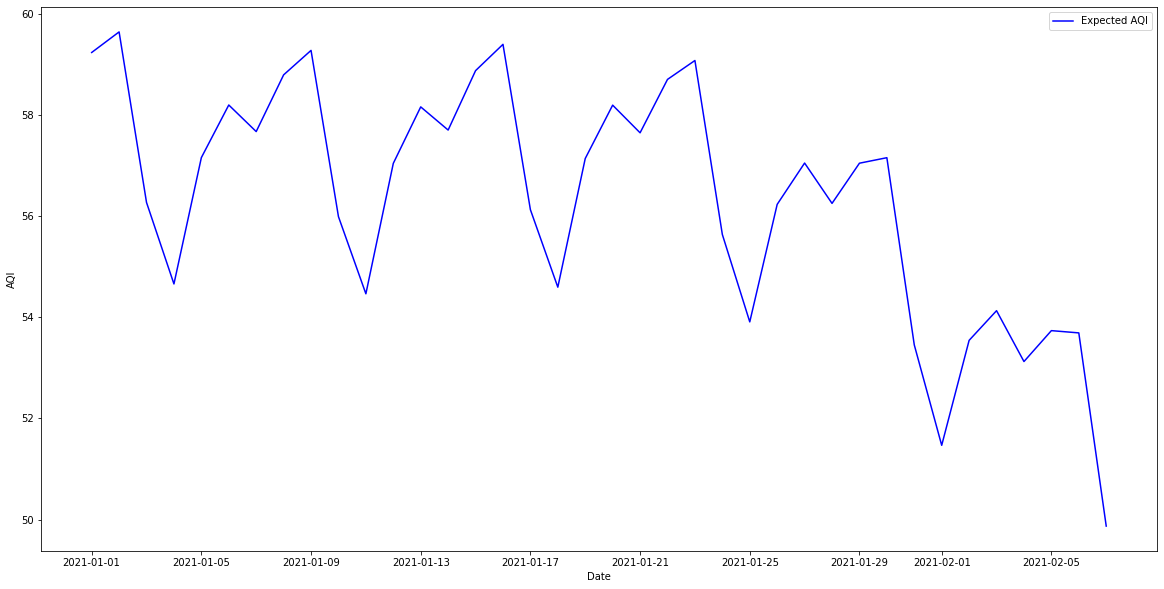

In [123]:
#future_aqi_result_updated['ds'] = future_aqi_result_updated['ds'].apply(pd.to_datetime)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(future_aqi_result_updated_pandas["ds"],future_aqi_result_updated_pandas["yhat"].to_list(),'b',label='Expected AQI')
plt.legend(loc='best')
plt.show()